### Kenya Energy Profile Analysis

This notebook analyzes Kenya's electricity sector from 2000-2024, examining generation sources, consumption patterns, production vs demand balance, and trade flows using International Energy Agency data.

#### 1. Data Import & Setup

In [1]:
import pandas as pd
from plotnine import * 

In [2]:
# Load electricity generation data
elec_df = pd.read_csv('data/International Energy Agency - electricity generation sources in Kenya.csv')
elec_df['electricity generation sources in Kenya'] = elec_df['electricity generation sources in Kenya'].str.replace('Solar PV', 'Solar')
elec_df.rename(columns={'electricity generation sources in Kenya': 'Source'}, inplace=True)
with pd.option_context('display.max_rows', None): 
    display(elec_df.head())

,Source,Value,Year,Units
0,Oil,2124.0,2000,GWh
1,Oil,1508.0,2001,GWh
2,Oil,1022.0,2002,GWh
3,Oil,920.0,2003,GWh
4,Oil,1038.0,2004,GWh


In [3]:
# Load consumption data
consumption_df = pd.read_csv('data/International Energy Agency - electricity final consumption by sector in Kenya.csv')
consumption_df['Value_gwh'] = round(consumption_df['Value'] / 3.6 , 2)  # Convert from TJ to GWh
consumption_df.rename(columns={'electricity final consumption by sector in Kenya': 'Sector'}, inplace=True)
consumption_df['Sector'] = consumption_df['Sector'].str.replace('Commercial and Public Services', 'Commercial')
with pd.option_context('display.max_rows', None):
    display(consumption_df.head())

,Sector,Value,Year,Units,Value_gwh
0,Industry,7549.0,2000,TJ,2096.94
1,Industry,8362.0,2001,TJ,2322.78
2,Industry,8820.0,2002,TJ,2450.00
3,Industry,9014.0,2003,TJ,2503.89
4,Industry,9853.0,2004,TJ,2736.94


In [4]:
# Load total production data
total_elec_df = pd.read_csv('data/International Energy Agency - Total electricity production, Kenya.csv')
with pd.option_context('display.max_rows', None):
    display(total_elec_df.head())

,Year,"Total electricity production, Kenya",Units
0,2000,4011,GWh
1,2001,4506,GWh
2,2002,4672,GWh
3,2003,4986,GWh
4,2004,5344,GWh


In [5]:
# Load imports/exports data
imports_exports_df = pd.read_csv('data/International Energy Agency - Kenya .csv')
with pd.option_context('display.max_rows', None):
    display(imports_exports_df.head())

,"electricity, Kenya",Value,Year,Units
0,Imports,198.0,2000,GWh
1,Imports,172.0,2001,GWh
2,Imports,222.0,2002,GWh
3,Imports,189.0,2003,GWh
4,Imports,162.0,2004,GWh


In [6]:
# Create peak demand data - manually entered from EPRA report 
peak_demand_data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Peak_Demand_MW': [1512, 1586, 1656, 1802, 1882, 1926, 1994, 2057, 2149, 2177]
}

peak_demand_df = pd.DataFrame(peak_demand_data)
peak_demand_df['yoy_change_MW'] = peak_demand_df['Peak_Demand_MW'].diff()
peak_demand_df

,Year,Peak_Demand_MW,yoy_change_MW
0,2015,1512,NaN
1,2016,1586,74.0
2,2017,1656,70.0
3,2018,1802,146.0
4,2019,1882,80.0
5,2020,1926,44.0
6,2021,1994,68.0
7,2022,2057,63.0
8,2023,2149,92.0
9,2024,2177,28.0


### 2. Electricity Generation Analysis

/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 19 rows containing missing values.


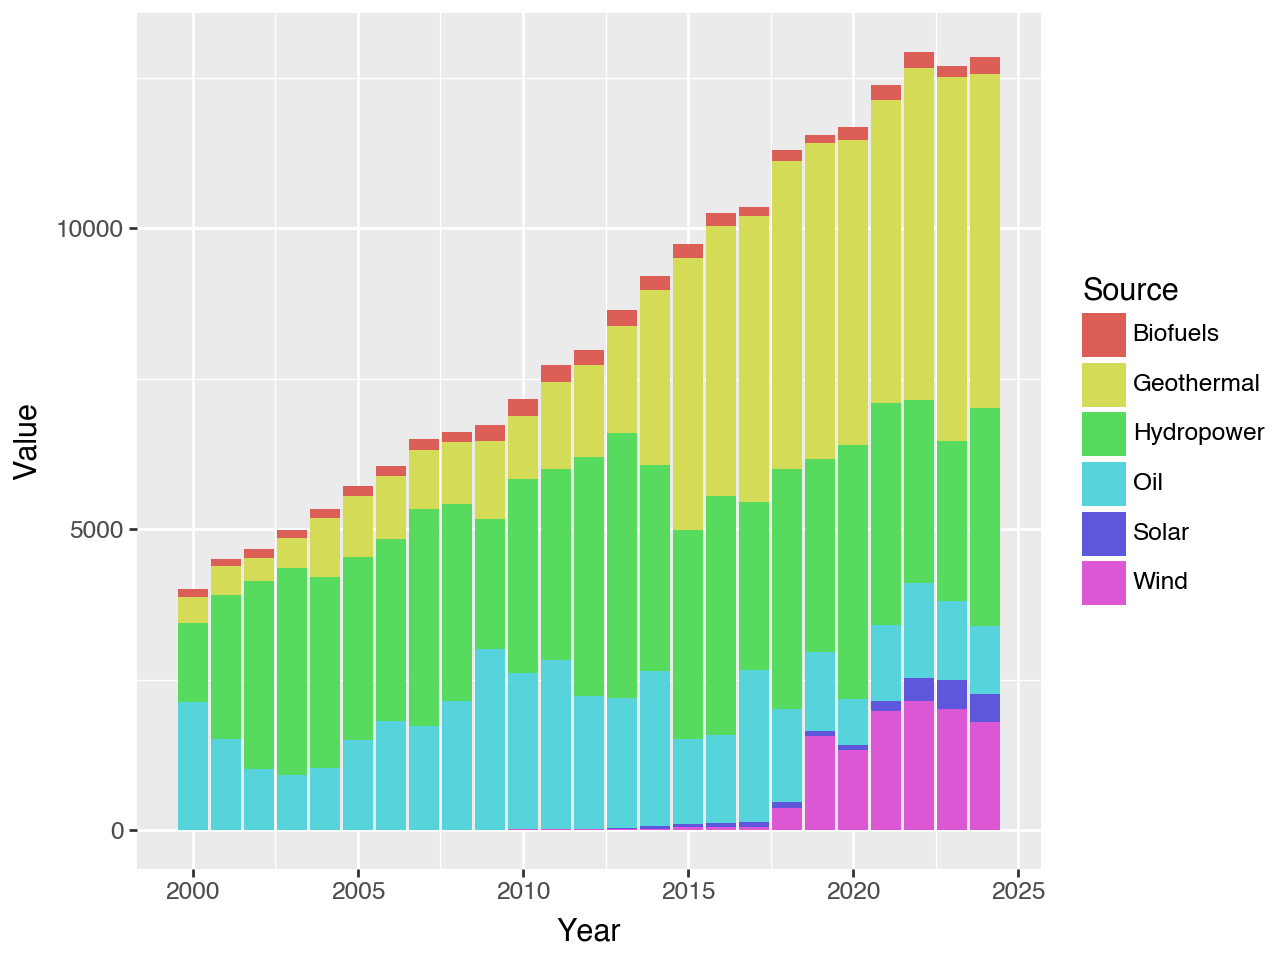

In [7]:
# Plot electricity generation by source over time (stacked area chart)
(
    ggplot(elec_df, aes(x='Year', y='Value', fill='Source')) +
    geom_col(position='stack')
)

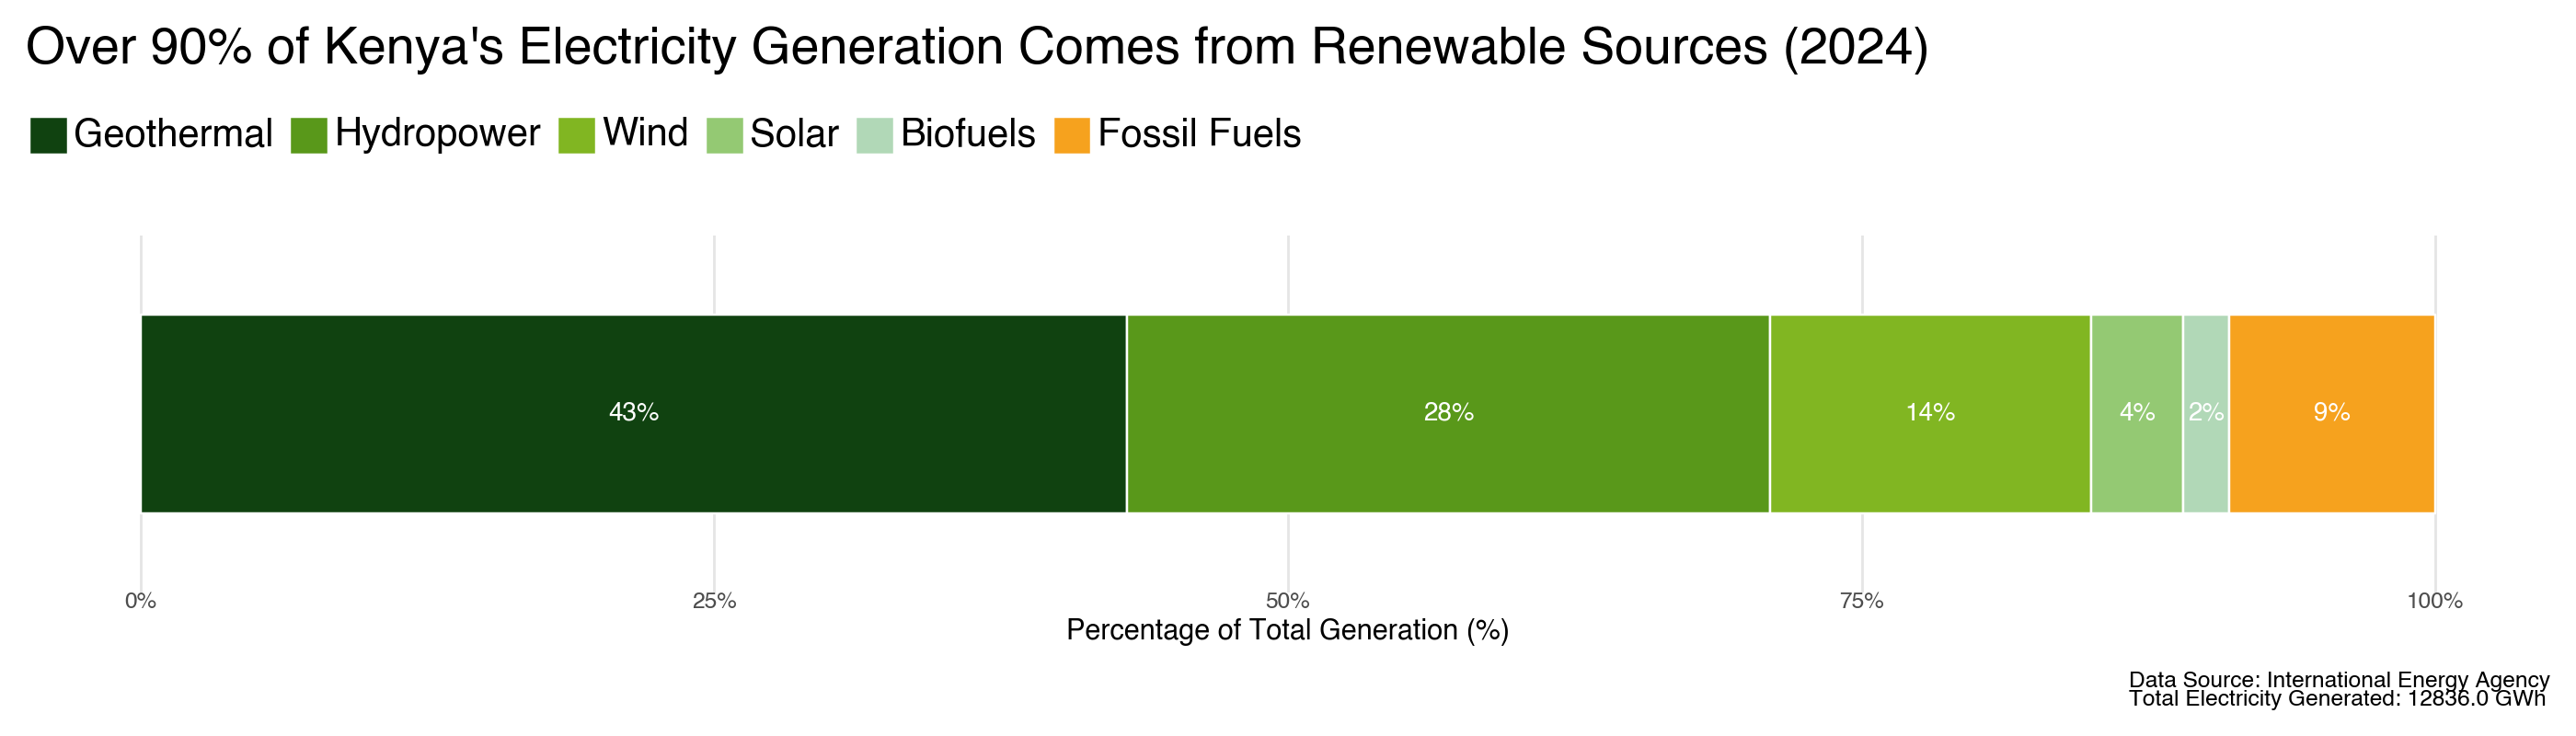

In [9]:
# Prepare 2024 generation data for visualization
elec_df_2024 = elec_df[elec_df['Year'] == 2024].reset_index(drop=True)
elec_df_2024['Category'] = '2024'
elec_df_2024['Percentage'] = round(elec_df_2024['Value'] / elec_df_2024['Value'].sum() * 100)
elec_df_2024['Percentage'] = elec_df_2024['Percentage'].astype(int)                         
elec_df_2024['Source'] = elec_df_2024['Source'].str.replace('Oil', 'Fossil Fuels')

source_order = ['Fossil Fuels', 'Biofuels',  'Solar', 'Wind', 'Hydropower', 'Geothermal']
elec_df_2024['Source'] = pd.Categorical(elec_df_2024['Source'], 
                                        categories=source_order, 
                                        ordered=True)

# Custom color palette
custom_colors = {
    'Fossil Fuels': '#F6A21E',     
    'Biofuels': '#B1D8B7', 
    'Solar': '#94C973',
    'Wind': '#81B622',
    'Hydropower': '#59981A',     
    'Geothermal': '#104210',        
}

(
    ggplot(elec_df_2024, aes(x='Category', y='Percentage', fill='Source'))
    + geom_col(position='stack', alpha=1, width=1, color='white', size=0.5)
    + geom_text(aes(label=elec_df_2024.apply(
        lambda row: f"{row['Percentage']}%", axis=1)),
        position=position_stack(vjust=0.5),
        size=10,
        color='white'
    )
    + scale_fill_manual(values=custom_colors)
    + scale_y_continuous(
        labels=lambda l: [f'{int(v)}%' for v in l],
        breaks=[0, 25, 50, 75, 100]
    )
    + scale_x_discrete(expand=(0.2, 0.2))  
    + labs(
        title="Over 90% of Kenya's Electricity Generation Comes from Renewable Sources (2024)",
        x='',
        y='Percentage of Total Generation (%)',  
        fill='',
        caption=f"Data Source: International Energy Agency\nTotal Electricity Generated: {elec_df_2024['Value'].sum()} GWh"
    ) 
    + coord_flip()
    + guides(fill=guide_legend(nrow=1, reverse=True))
    + theme_minimal()
    + theme(
        figure_size=(14, 4),
        plot_title=element_text(size=20, weight='bold', margin={'b': 15}, ha='left'),
        plot_subtitle=element_text(size=12, margin={'b': 20}, ha='left'),
        axis_text_y = element_blank(),
        axis_title_y=element_text(size=11, margin={'r': 10}),
        legend_position='top',
        legend_direction='horizontal',
        legend_box='horizontal',
        legend_title=element_blank(),
        legend_text=element_text(size=15),
        legend_justification='left',
        legend_box_just='left',
        panel_grid_major_y=element_blank(),
        panel_grid_minor=element_blank()
    )
)

In [10]:
# Display total electricity generation for 2024
print(f"Total electricity generation in 2024: {elec_df_2024['Value'].sum()} GWh")

Total electricity generation in 2024: 12836.0 GWh


### 3. Electricity Consumption Analysis

/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 39 rows containing missing values.


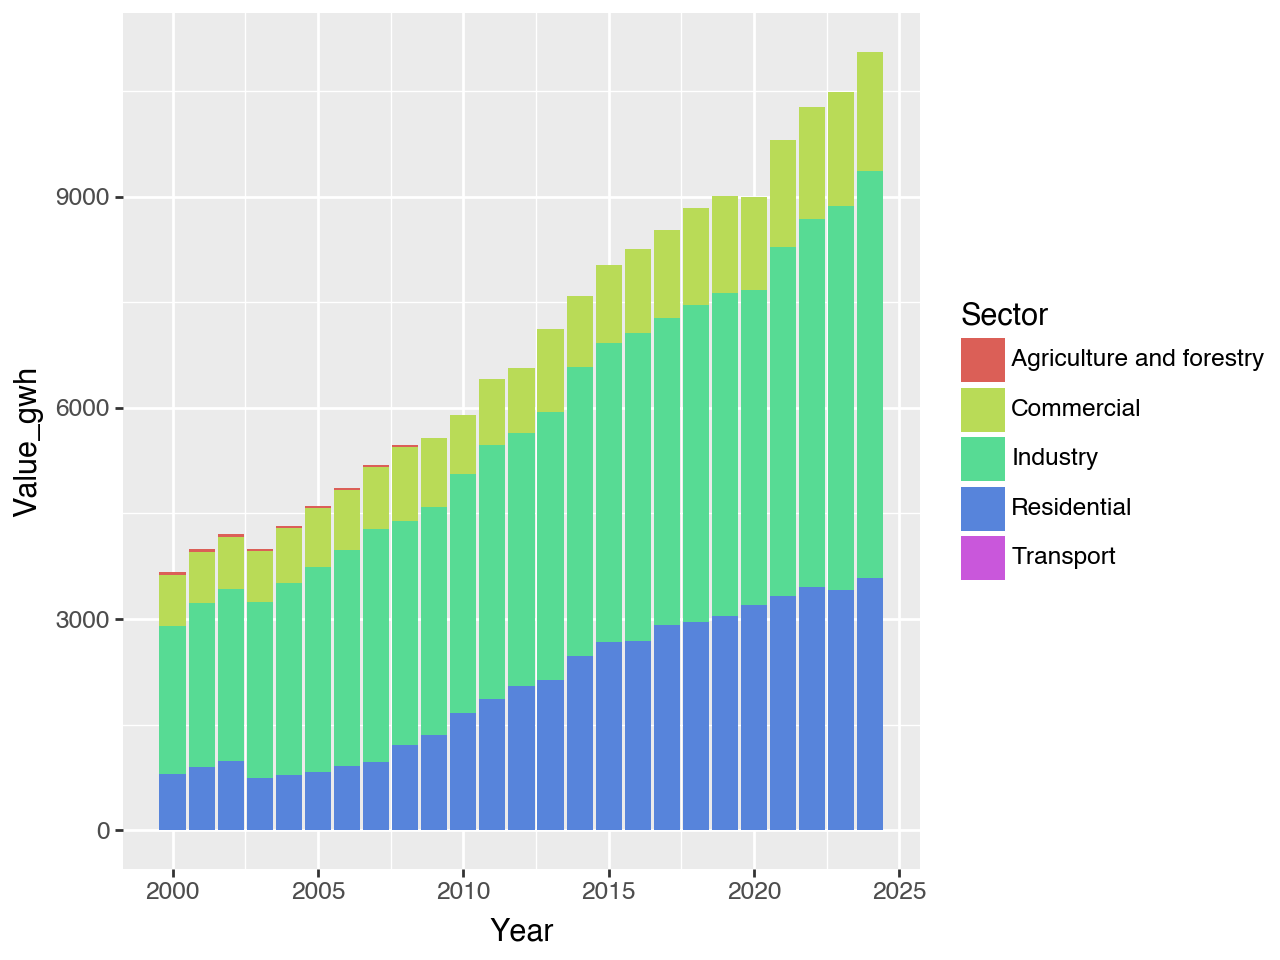

In [11]:
# Plot basic consumption by sector over time (stacked bars)
(
    ggplot(consumption_df, aes(x='Year', y='Value_gwh', fill='Sector')) 
    + geom_col(position='stack')
)

/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_72123/3824119781.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_72123/3824119781.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 12 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 12 row

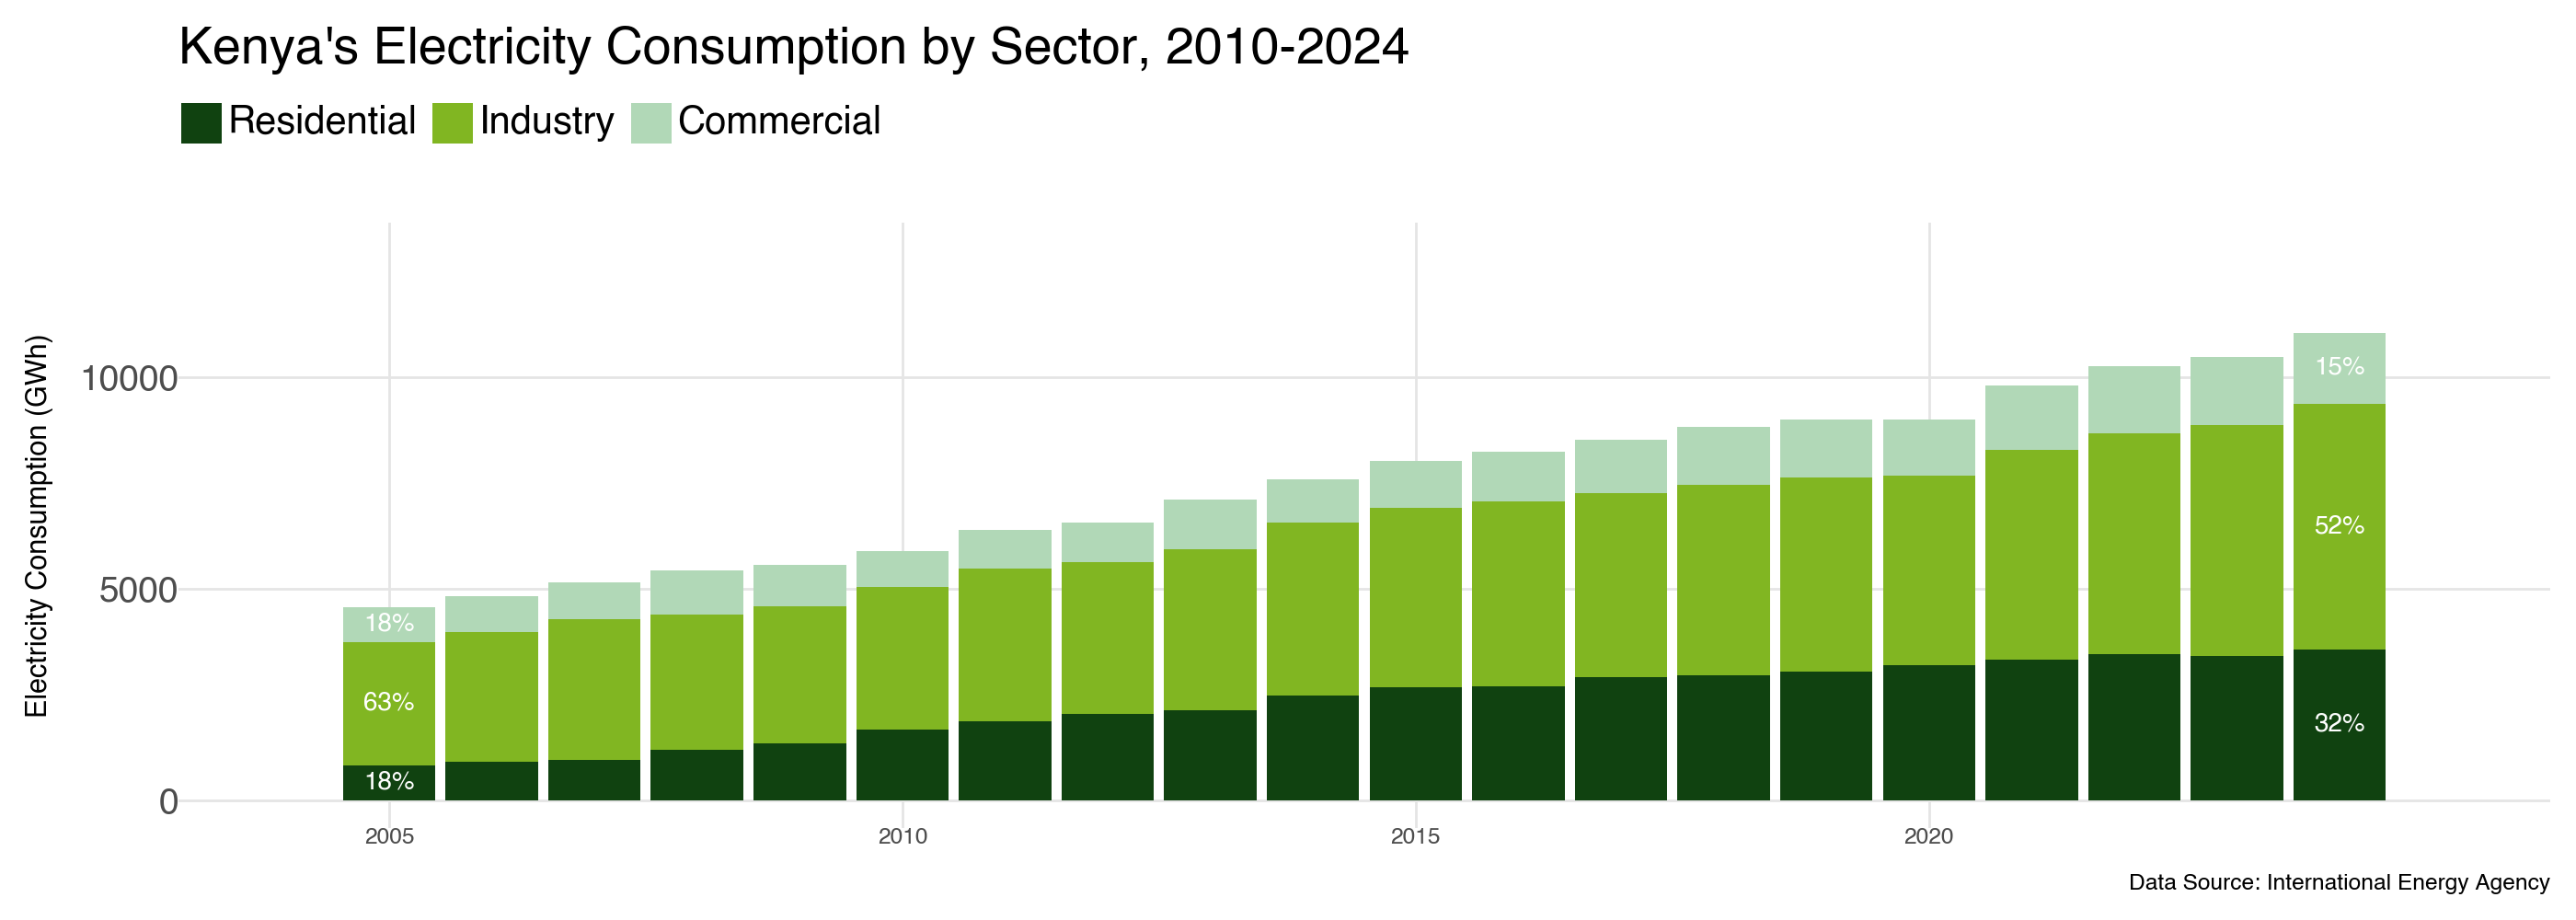

In [12]:
# Prepare consumption data for visualization
custom_colors = {
    'Commercial': '#B1D8B7', 
    'Industry': '#81B622',
    'Residential': '#104210',        
}

consumption_df_plot = consumption_df[consumption_df['Sector'].isin(['Residential', 'Commercial', 'Industry'])]
consumption_df_plot['percentage'] = consumption_df_plot['Value_gwh'] / consumption_df_plot.groupby('Year')['Value_gwh'].transform('sum') * 100
consumption_df_plot['percentage'] = consumption_df_plot['percentage'].astype(int)

(
    ggplot(consumption_df_plot, aes(x='Year', y='Value_gwh', fill='Sector')) 
    + geom_col(position='stack')
    + geom_text(
        aes(label=consumption_df_plot.apply(
            lambda row: f"{row['percentage']}%" if row['Year'] == 2024 or row['Year'] == 2005 else '',
            axis=1
        )),
        position=position_stack(vjust=0.5),
        size=10,
        color='white'
    )
    + scale_fill_manual(values=custom_colors)
    + scale_y_continuous(
        limits=(0, 13000),
        breaks=range(0, 13000, 5000)
    )
    + scale_x_continuous(
        limits=(2004, 2025),
        breaks=range(2005, 2025, 5)
    )
    + theme_minimal()
    + guides(fill=guide_legend(nrow=1, reverse=True))
    + labs(
        title="Kenya's Electricity Consumption by Sector, 2010-2024",
        x='',
        y='Electricity Consumption (GWh)',  
        fill='',
        caption='Data Source: International Energy Agency'
    ) 
    + theme(
        figure_size=(14, 5),
        plot_title=element_text(size=20, weight='bold', margin={'b': 10}, ha='left'),
        plot_subtitle=element_text(size=12, margin={'b': 20}, ha='left'),
        axis_text_y=element_text(size=14),
        axis_title_x=element_text(size=11, margin={'t': 10}),
        legend_position='top',
        legend_direction='horizontal',
        legend_box='horizontal',
        legend_title=element_blank(),
        legend_text=element_text(size=15),
        legend_justification='left',
        legend_box_just='left',
        panel_grid_minor=element_blank()
    )
)

/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 1 rows containing missing values.


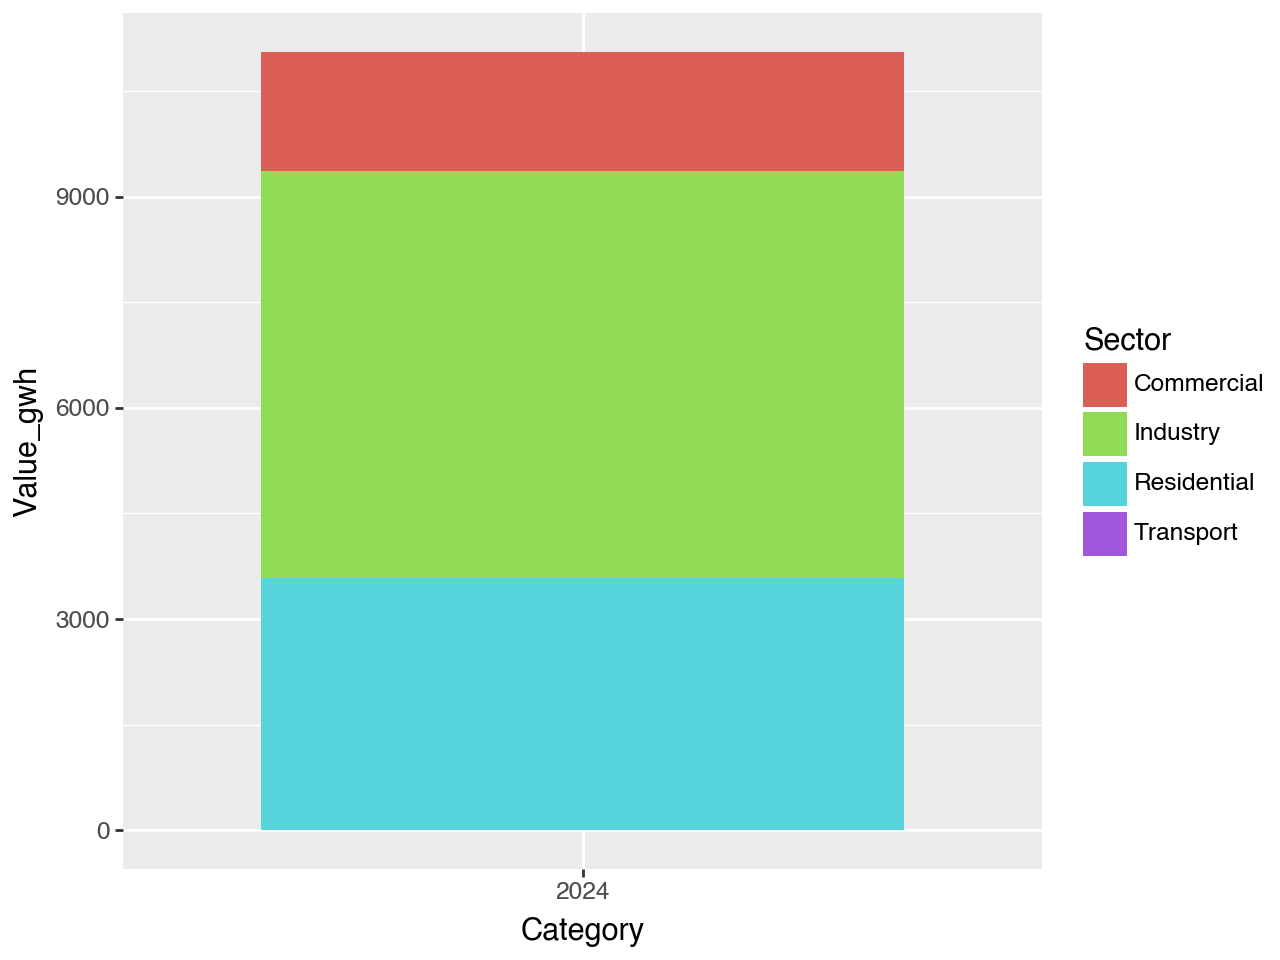

In [13]:
# Plot 2024 consumption by sector (simple stacked bar)
consumption_df_2024 = consumption_df[consumption_df['Year'] == 2024].reset_index(drop=True)
consumption_df_2024['Category'] = '2024'

(
    ggplot(consumption_df_2024, aes(x='Category', y='Value_gwh', fill='Sector'))
    + geom_col(position='stack', alpha=1, width=0.7)
)

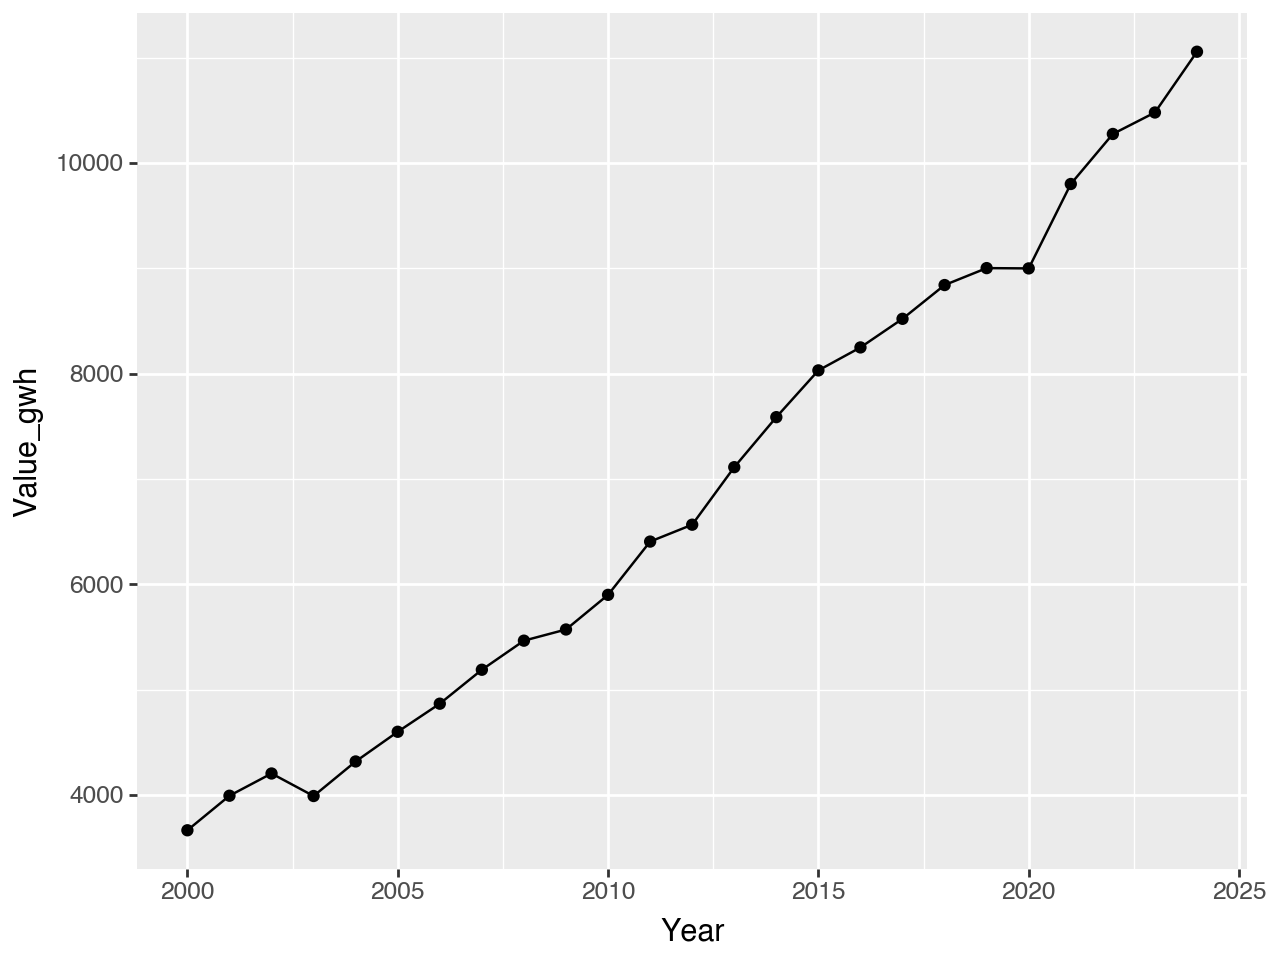

In [14]:
# Calculate total consumption by year for trend analysis
consumption_df_yearly_total = consumption_df.groupby('Year')['Value_gwh'].sum().reset_index()

(
    ggplot(consumption_df_yearly_total, aes(x='Year', y='Value_gwh'))
    + geom_line()
    + geom_point()
)

/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


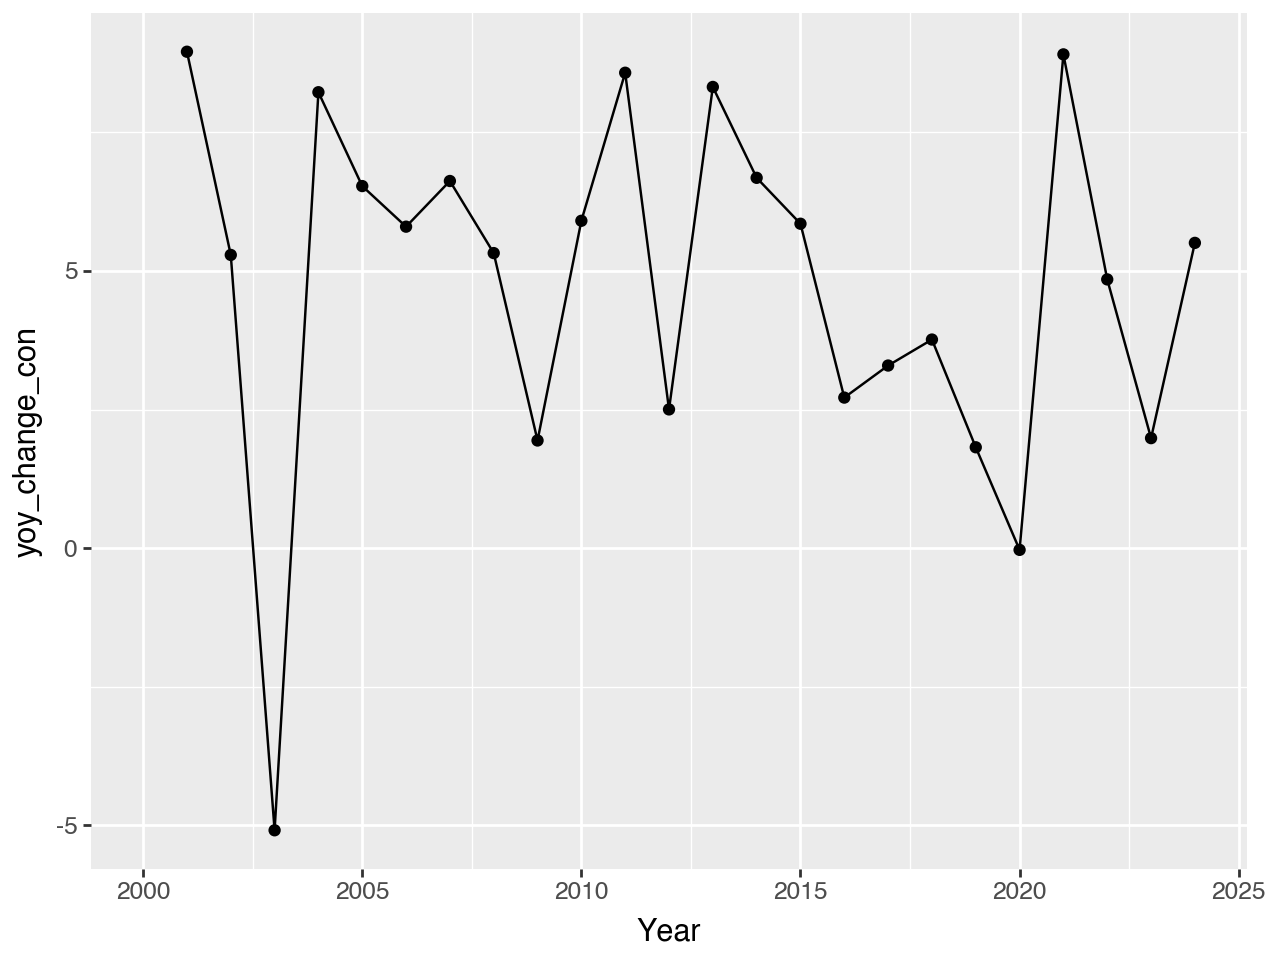

In [15]:
# Plot year-over-year percentage change in consumption
consumption_df_yearly_total['yoy_change_con'] = consumption_df_yearly_total['Value_gwh'].pct_change() * 100
(
    ggplot(consumption_df_yearly_total, aes(x='Year', y='yoy_change_con'))
    + geom_line()
    + geom_point()
)

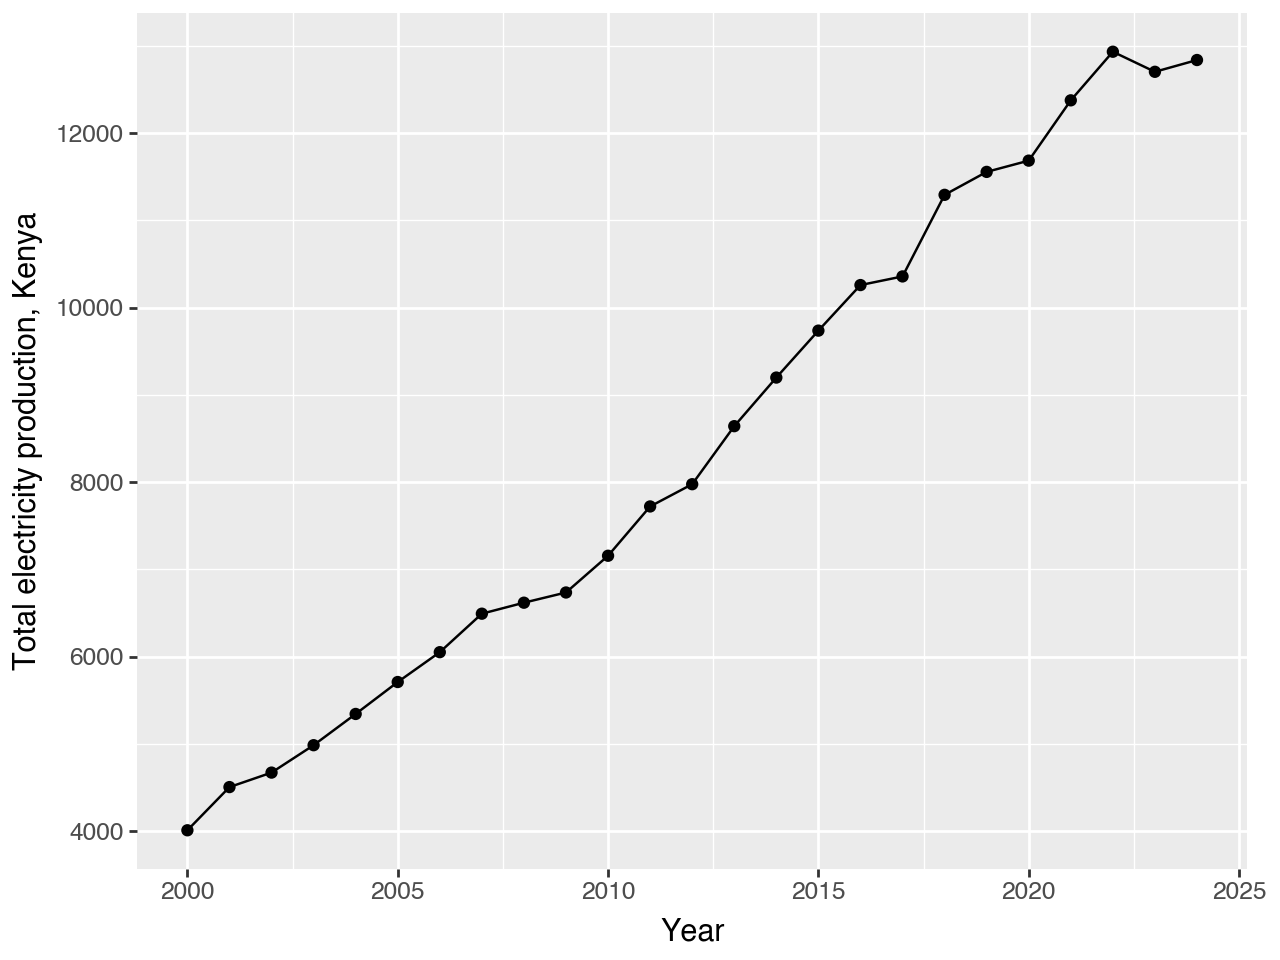

In [16]:
# Plot total electricity production over time
(
    ggplot(total_elec_df, aes(x='Year', y='Total electricity production, Kenya')) 
    + geom_line()
    + geom_point()
)

/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


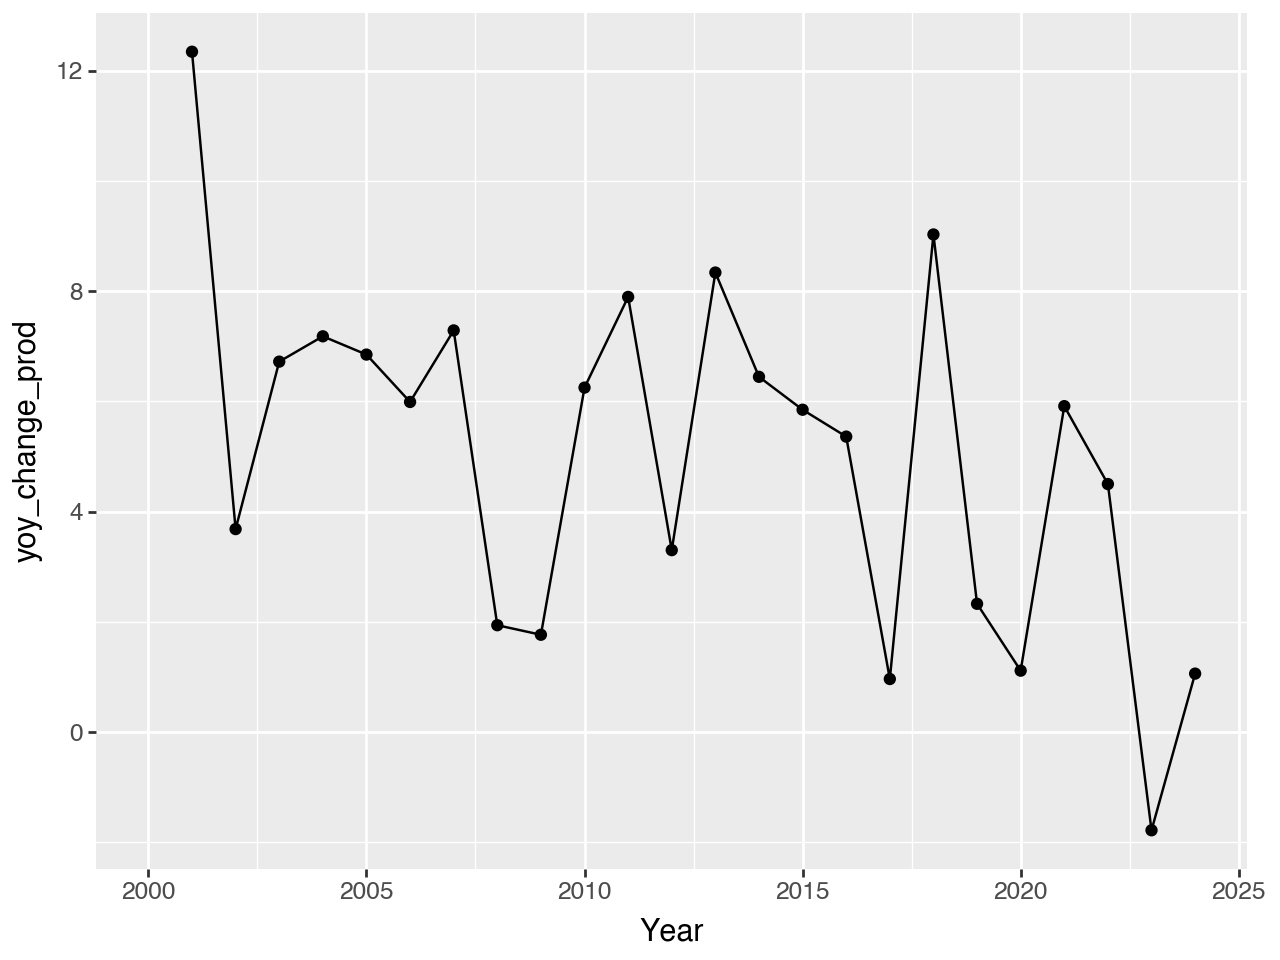

In [17]:
# Plot year-over-year percentage change in production
total_elec_df['yoy_change_prod'] = total_elec_df['Total electricity production, Kenya'].pct_change() * 100

(
    ggplot(total_elec_df, aes(x='Year', y='yoy_change_prod')) 
    + geom_line()
    + geom_point()
)

/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


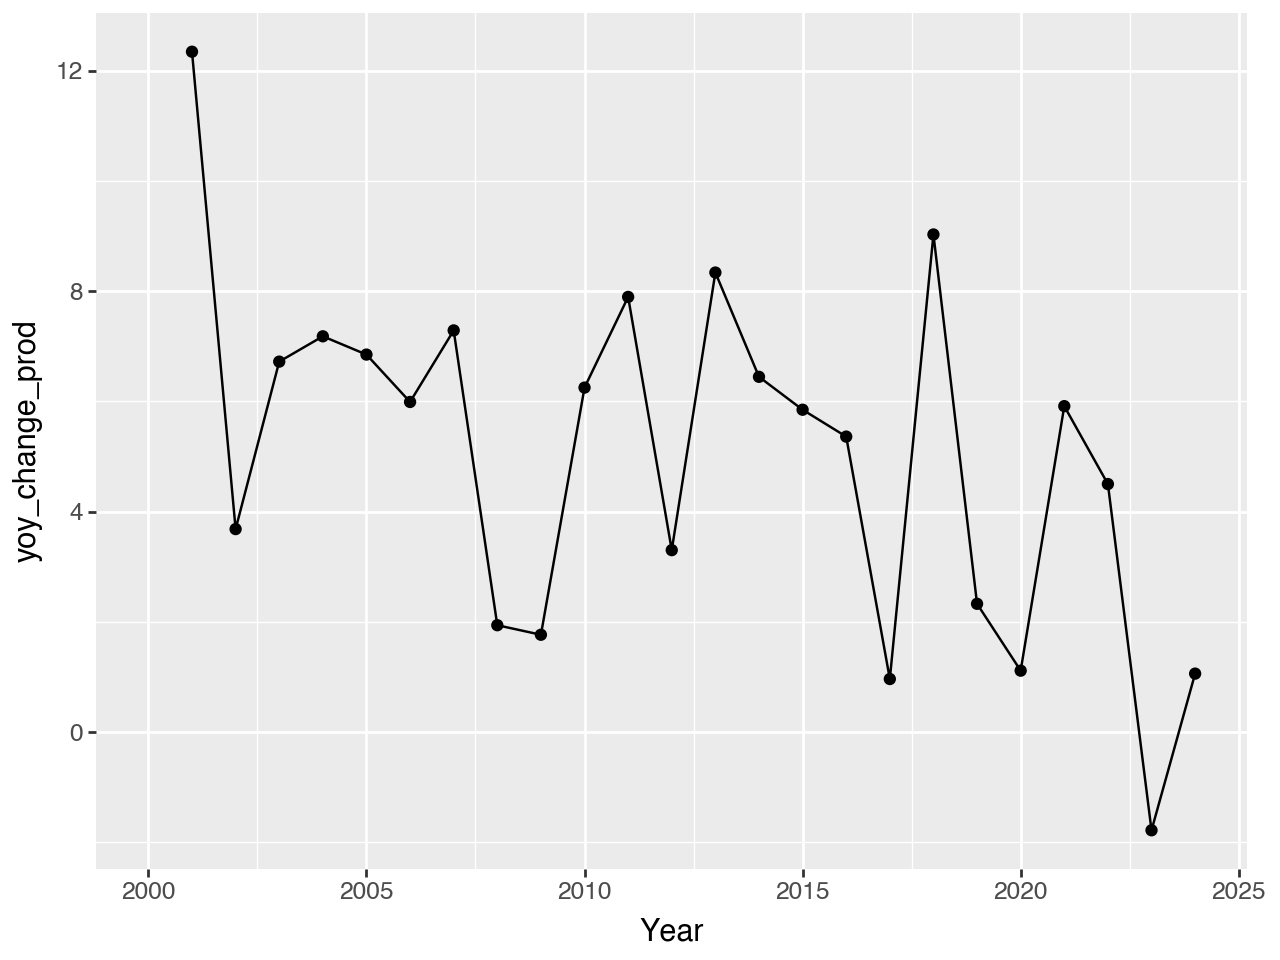

In [18]:
total_elec_df['yoy_change_prod'] = total_elec_df['Total electricity production, Kenya'].pct_change() * 100

(
    ggplot(total_elec_df, aes(x='Year', y='yoy_change_prod')) 
    + geom_line()
    + geom_point()
)

In [20]:
# Combine production and consumption data for comparison analysis
combined_df = pd.merge(total_elec_df, consumption_df_yearly_total, on='Year', how='inner')
combined_df.rename(columns={
    'Total electricity production, Kenya': 'Production',
    'Value_gwh': 'Consumption'
}, inplace=True)

combined_df['Net'] = combined_df['Production'] - combined_df['Consumption']
combined_df['net_yoy_change'] = combined_df['Net'].pct_change() * 100

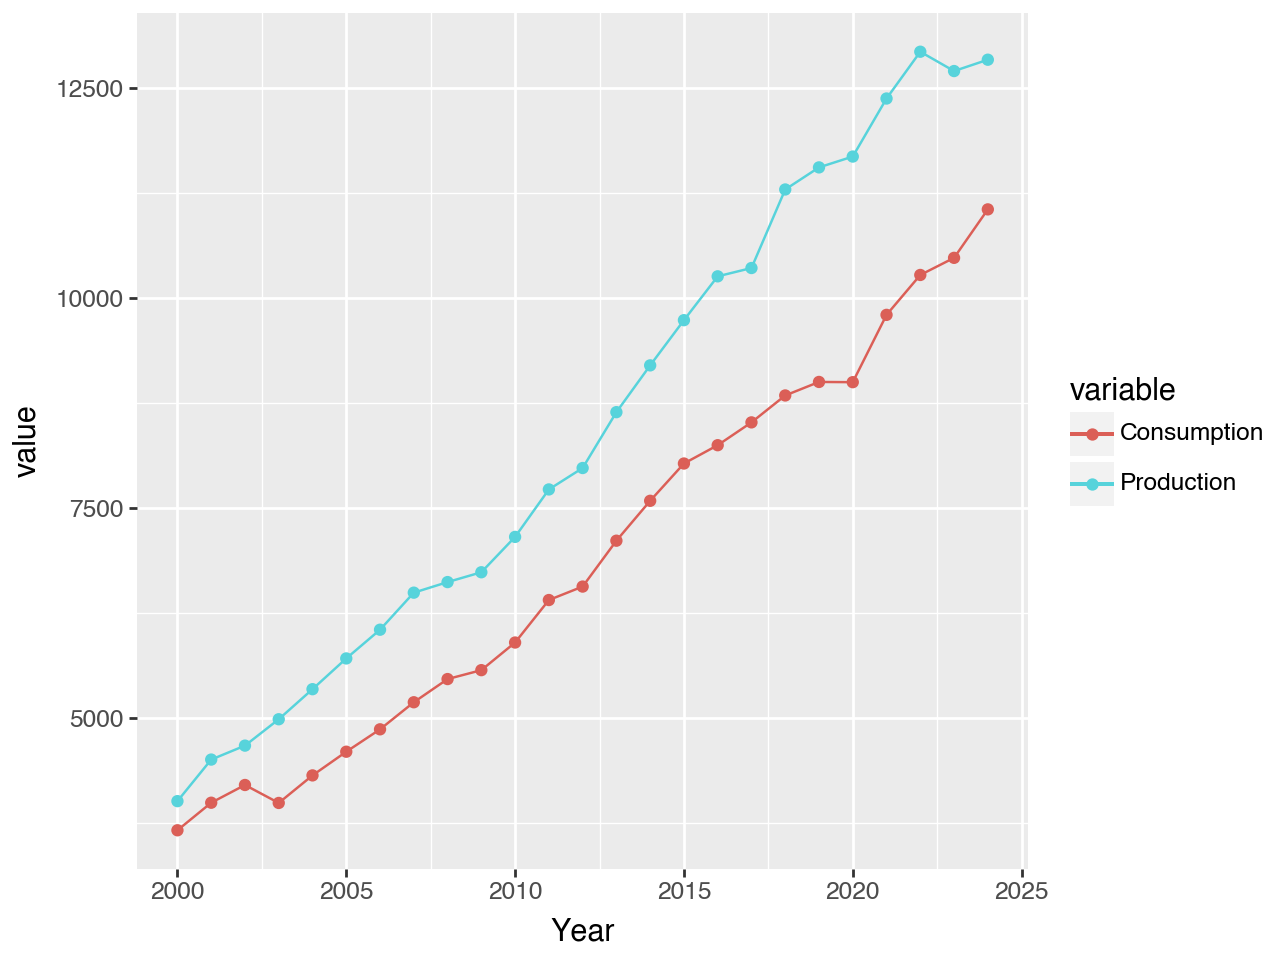

In [21]:
# Plot production vs consumption trends on same chart
combined_df_long = pd.melt(combined_df, id_vars=['Year'], value_vars=['Production', 'Consumption'])

(
    ggplot(combined_df_long, aes(x='Year', y='value', color='variable'))
    + geom_line()
    + geom_point()
)

/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


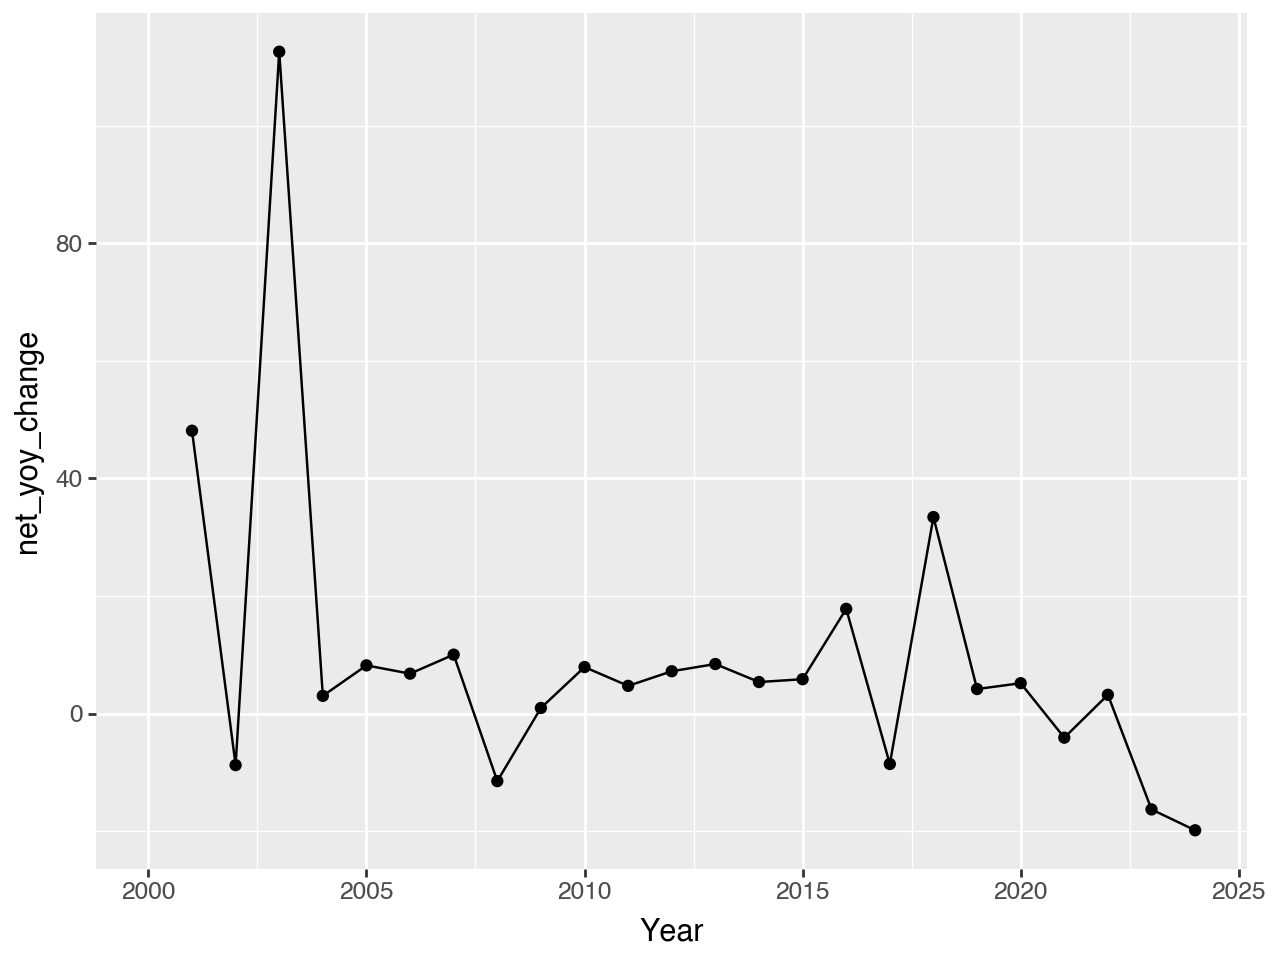

In [22]:
# Plot year-over-year change in net surplus (production minus consumption)
(
    ggplot(combined_df, aes(x='Year', y='net_yoy_change')) 
    + geom_line()
    + geom_point()
)

/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


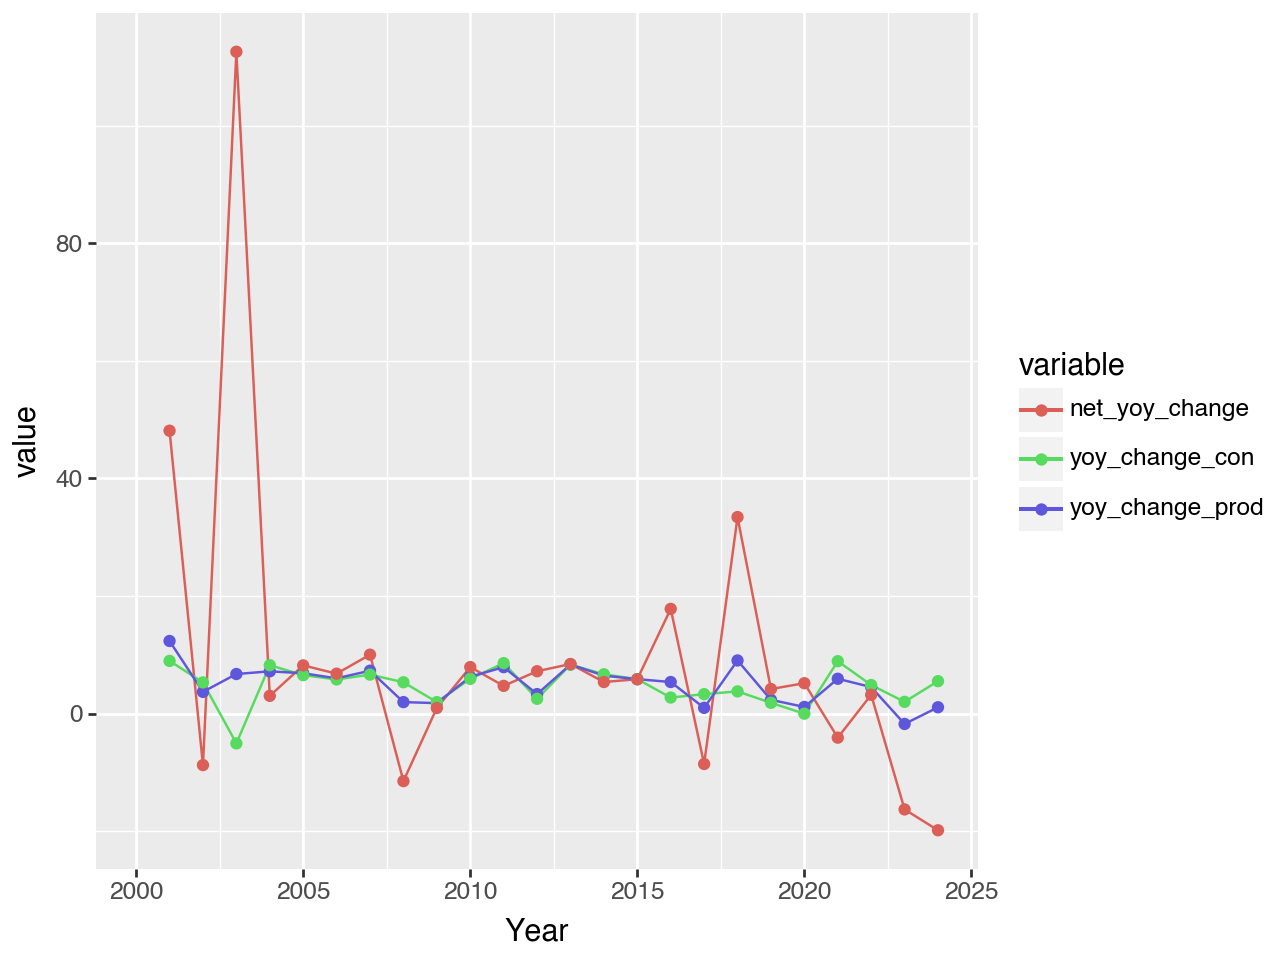

In [23]:
# Compare year-over-year changes in production, consumption, and net surplus
combined_df_yoy_long = pd.melt(combined_df, id_vars=['Year'], value_vars=['yoy_change_prod', 'yoy_change_con', 'net_yoy_change'])

(
    ggplot(combined_df_yoy_long, aes(x='Year', y='value', color='variable'))
    + geom_line()
    + geom_point()
)

/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


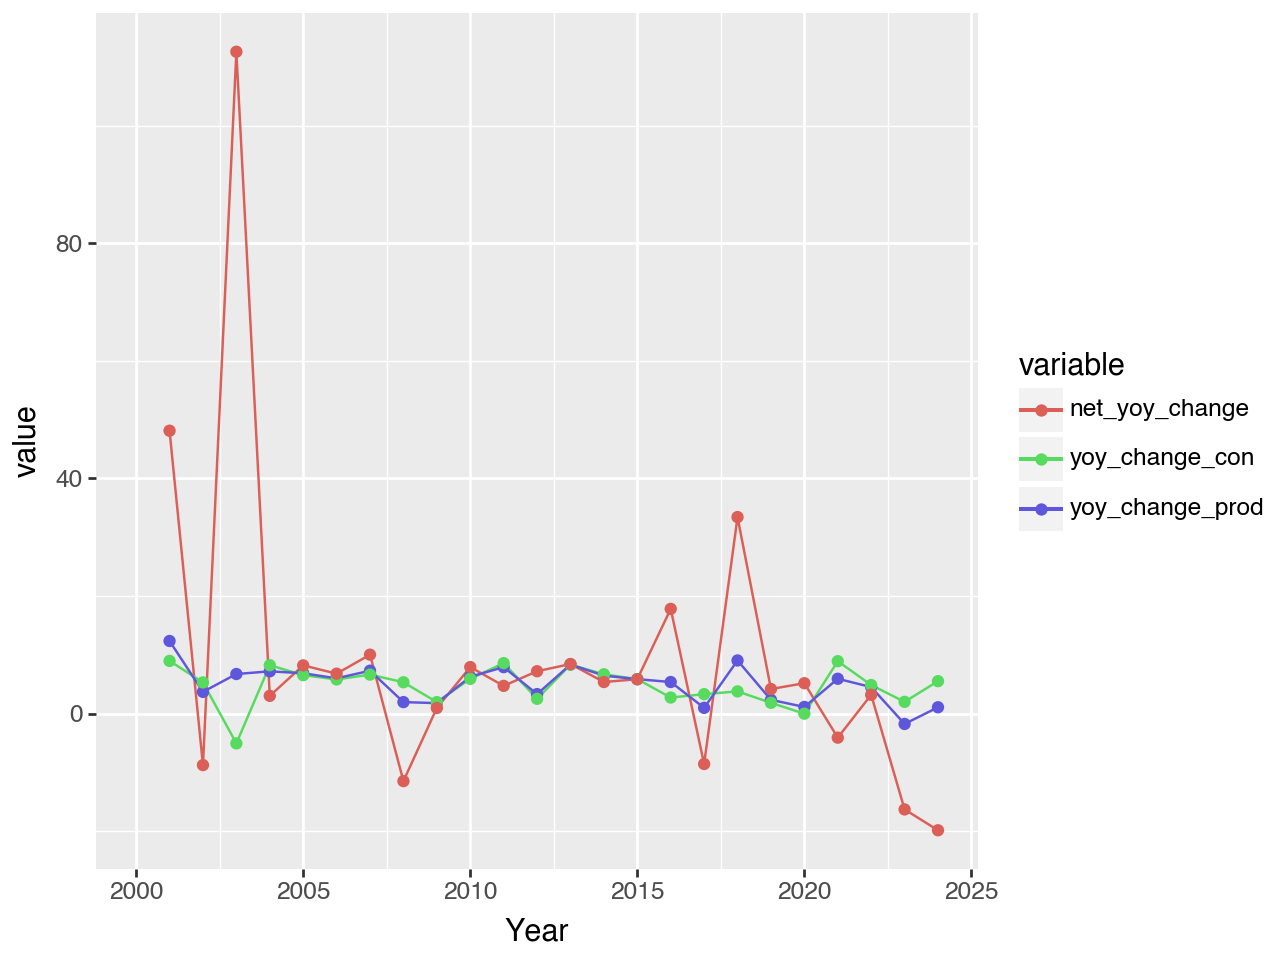

In [24]:
combined_df_yoy_long = pd.melt(combined_df, id_vars=['Year'], value_vars=['yoy_change_prod', 'yoy_change_con', 'net_yoy_change'])

(
    ggplot(combined_df_yoy_long, aes(x='Year', y='value', color='variable'))
    + geom_line()
    + geom_point()
)



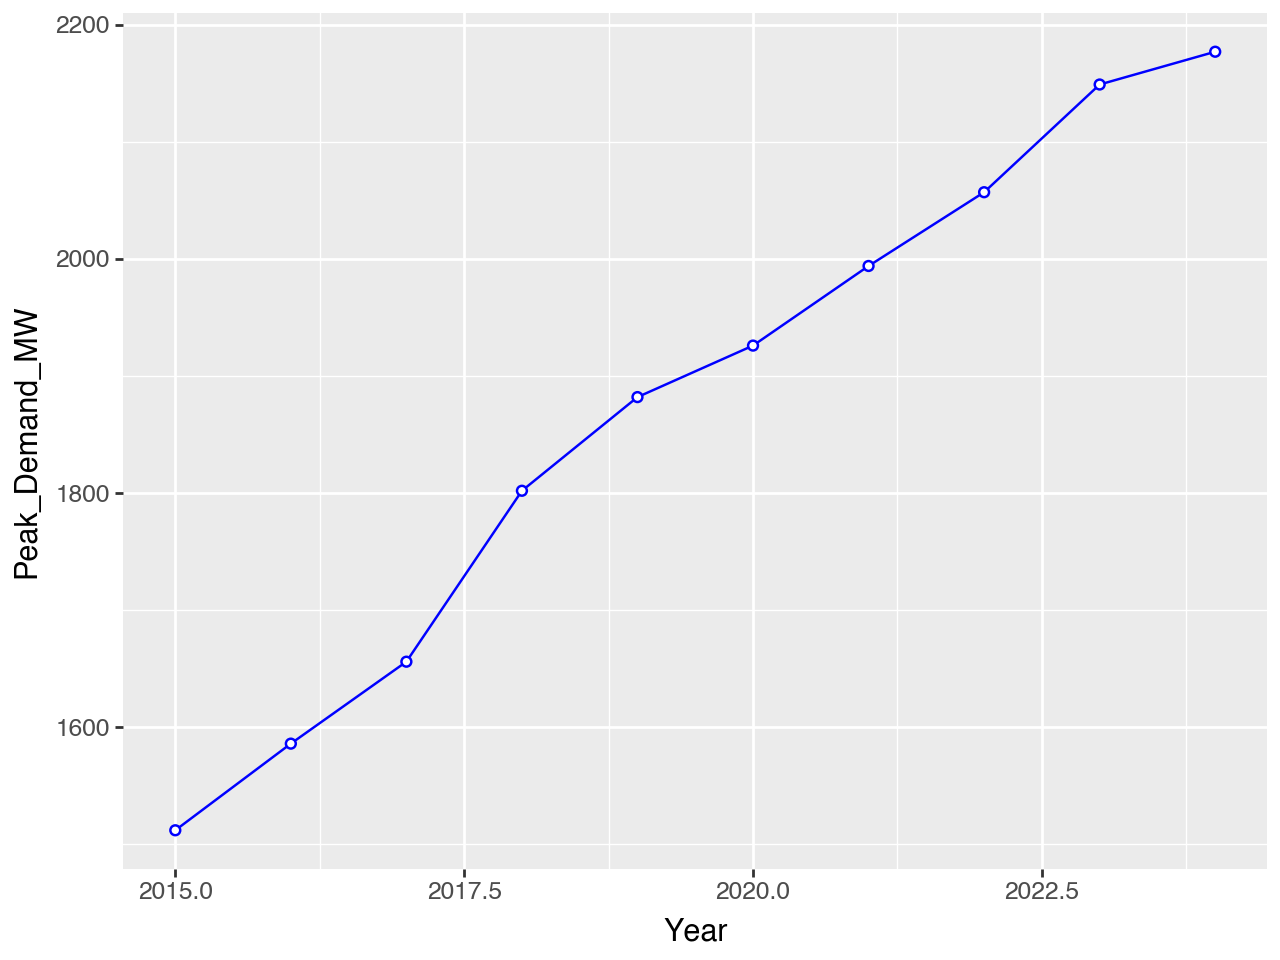

In [25]:
# Plot peak demand trend over time
(
    ggplot(peak_demand_df, aes(x='Year', y='Peak_Demand_MW')) 
    + geom_line(color='blue')
    + geom_point(color='blue', fill='white')
)

### 6. Peak Demand Analysis

/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


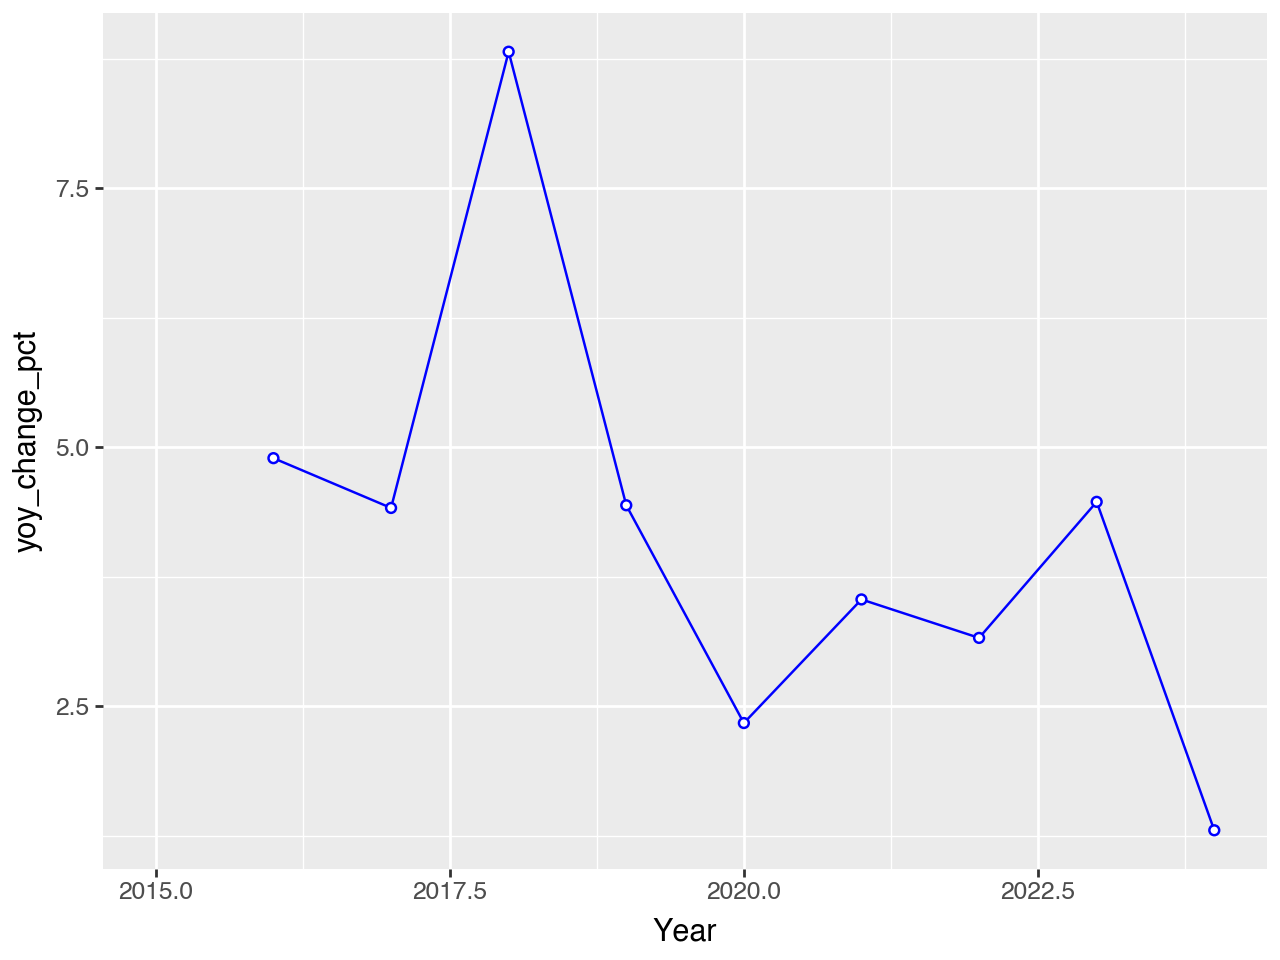

In [26]:
# Plot year-over-year percentage change in peak demand
peak_demand_df['yoy_change_pct'] = peak_demand_df['Peak_Demand_MW'].pct_change() * 100

(
    ggplot(peak_demand_df, aes(x='Year', y='yoy_change_pct')) 
    + geom_line(color='blue')
    + geom_point(color='blue', fill='white')
)

In [27]:
# Calculate peak demand growth from 2015 to 2024
peak_demand_2015 = peak_demand_df[peak_demand_df['Year'] == 2015]['Peak_Demand_MW'].values[0]
peak_demand_2024 = peak_demand_df[peak_demand_df['Year'] == 2024]['Peak_Demand_MW'].values[0]

peak_demand_increase = peak_demand_2024 - peak_demand_2015
peak_demand_percentage_increase = (peak_demand_increase / peak_demand_2015) * 100

print(f"Peak Demand in 2015: {peak_demand_2015} MW")
print(f"Peak Demand in 2024: {peak_demand_2024} MW")
print(f"Increase in Peak Demand from 2015 to 2024: {peak_demand_increase} MW")
print(f"Percentage Increase in Peak Demand from 2015 to 2024: {peak_demand_percentage_increase:.2f}%")

Peak Demand in 2015: 1512 MW
Peak Demand in 2024: 2177 MW
Increase in Peak Demand from 2015 to 2024: 665 MW
Percentage Increase in Peak Demand from 2015 to 2024: 43.98%


/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


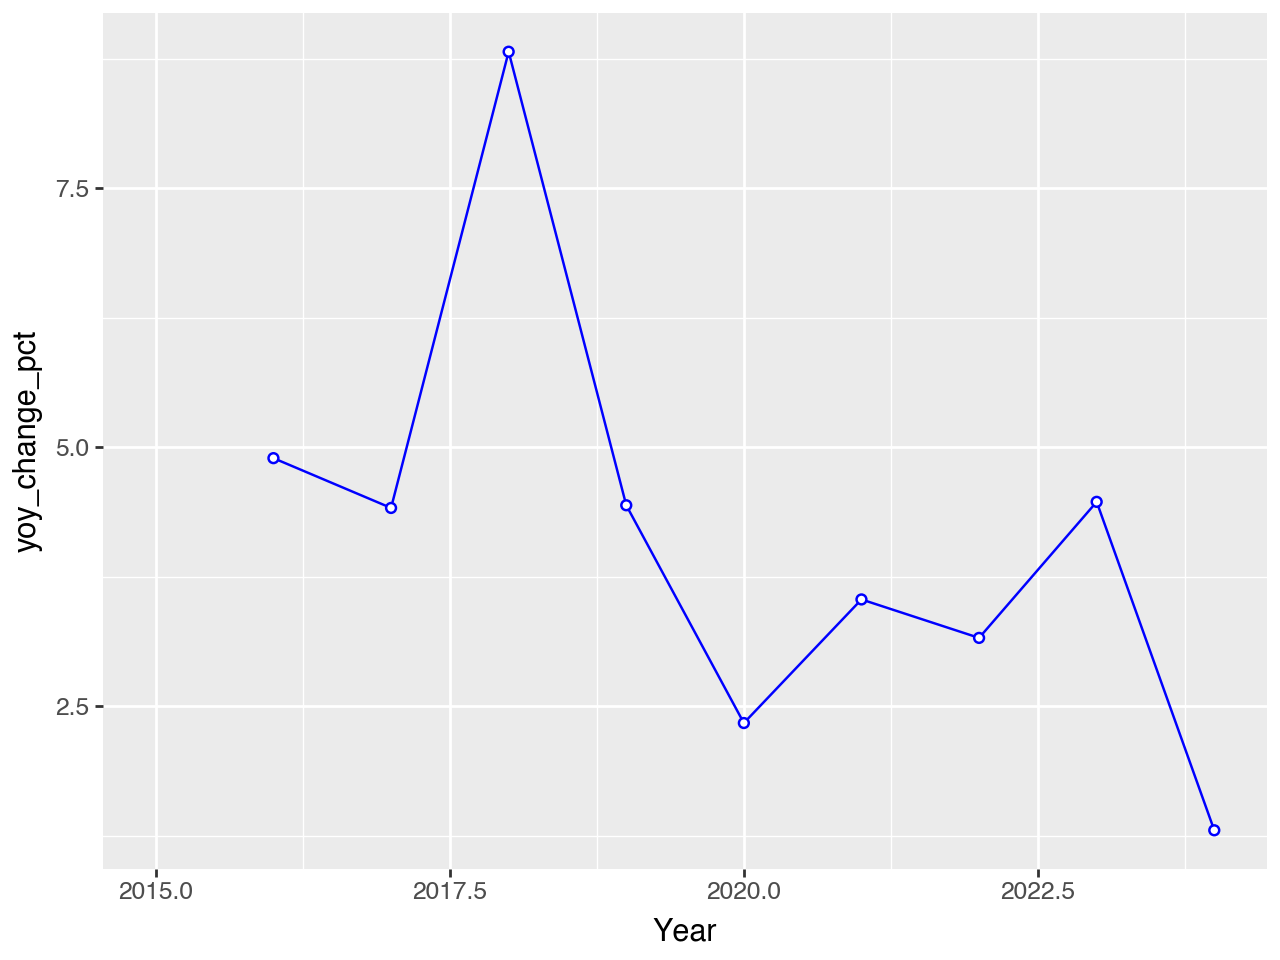

In [28]:
peak_demand_df['yoy_change_pct'] = peak_demand_df['Peak_Demand_MW'].pct_change() * 100

(
    ggplot(peak_demand_df, aes(x='Year', y='yoy_change_pct')) 
    + geom_line(color='blue')
    + geom_point(color='blue', fill='white')
)